# 예측 설명하기

특성 중요도 도구를 사용하면 전체적으로 유용하다고 판명된 특성을 구별할 수 있습니다. 또한 **특정 샘플**에 중요한 특성을 식별할 수도 있습니다. 머신러닝 에디터의 경우 모델을 사용해 주어진 특정 입력에 대한 추천을 만들기 때문에 이런 성질은 특히 유용합니다. 그외에도 이 방법은 특성 중요도를 제공하는 모델을 사용할 필요가 없습니다. 따라서 블랙 박스(black box) 모델에 사용할 수 있습니다. 여기서는 [LIME](https://github.com/marcotcr/lime)이라는 블랙 박스 설명 도구를 사용하겠습니다.

먼저 데이터를 로드합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import random
from collections import defaultdict
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    add_text_features_to_df,
    get_vectorized_series, 
    get_feature_vector_and_label
)
from ml_editor.model_v1 import get_model_probabilities_for_input_texts
from lime.lime_text import LimeTextExplainer
random.seed(40)

data_path = Path('data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

그다음 특성을 추가하고 데이터를 분할합니다.

In [2]:
df = add_text_features_to_df(df.loc[df["is_question"]].copy())
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

사전 훈련된 모델과 벡터화 객체를 로드합니다.

In [3]:
model_path = Path("models/model_1.pkl")
clf = joblib.load(model_path) 
vectorizer_path = Path("models/vectorizer_1.pkl")
vectorizer = joblib.load(vectorizer_path) 

텍스트를 벡터화하고 모델을 위해 특성을 준비합니다.

In [4]:
train_df["vectors"] = get_vectorized_series(train_df["full_text"].copy(), vectorizer)
test_df["vectors"] = get_vectorized_series(test_df["full_text"].copy(), vectorizer)

features = [
                "action_verb_full",
                "question_mark_full",
                "text_len",
                "language_question",
            ]
X_train, y_train = get_feature_vector_and_label(train_df, features)
X_test, y_test = get_feature_vector_and_label(test_df, features)

이제 LIME을 사용해 **특정 샘플**에 대한 모델의 예측을 설명할 함수를 만듭니다.

In [5]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, get_model_probabilities_for_input_texts, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Low score","High score"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

여기에서는 특히 분류기가 질문에 있는 어떤 종류의 컨텐츠에 의존하는지를 찾는 것에 관심이 있습니다. 아래의 예시처럼 특정 샘플에 대한 설명을 시각화하여 이를 확인할 수 있습니다.

In [ ]:
visualize_one_exp(list(test_df["full_text"]), list(y_test), 7)

Index: 7
True class: High score


*아래 이미지는 출력 예시입니다*
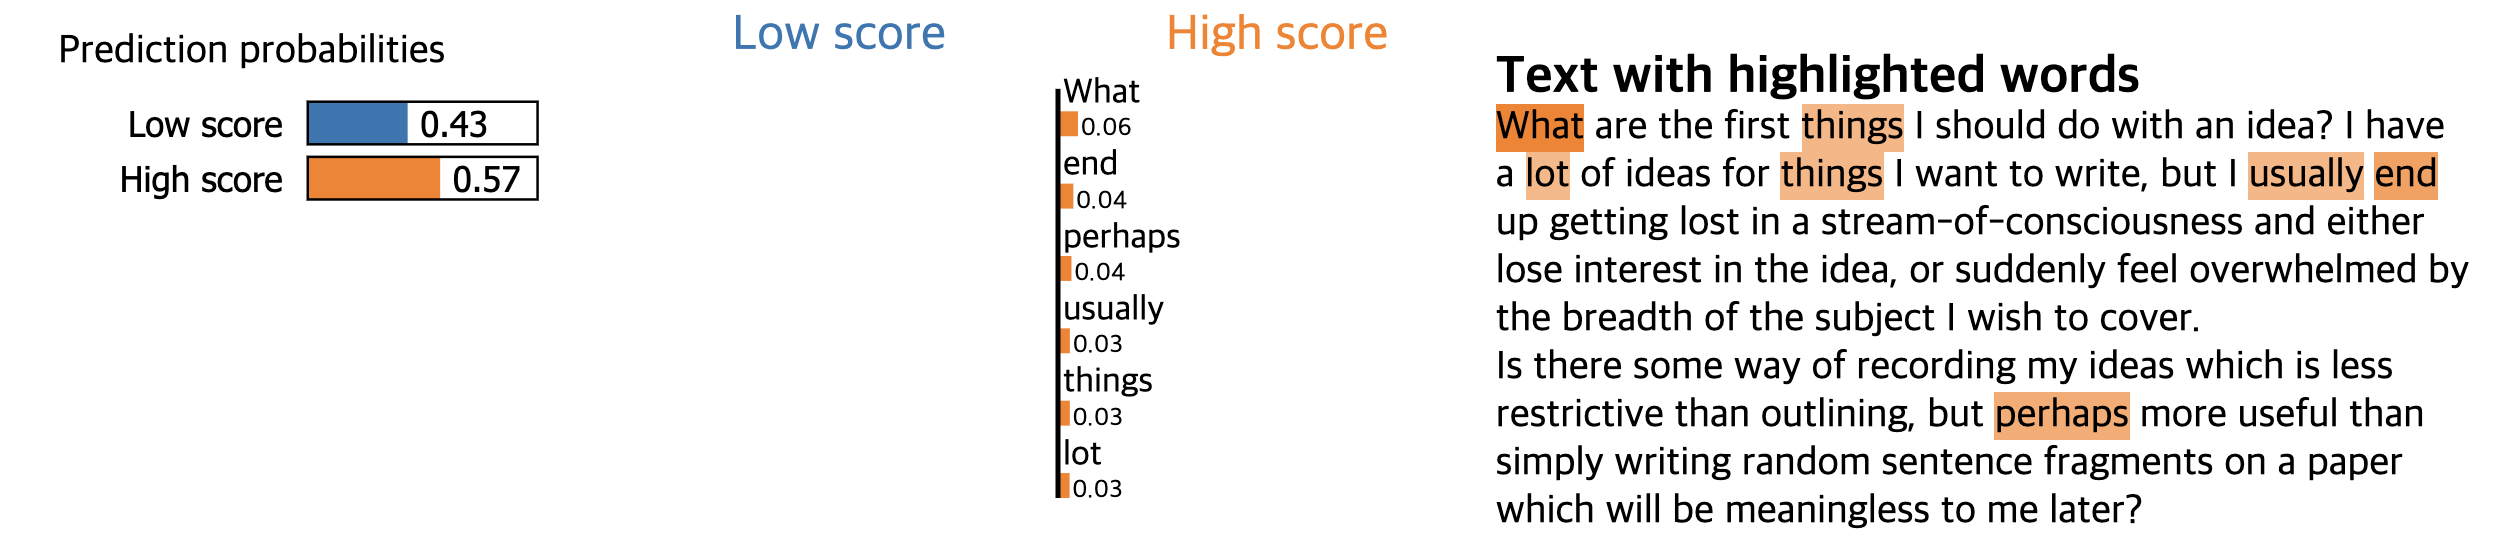

In [ ]:
visualize_one_exp(list(test_df["full_text"]), list(y_test), 12)

*아래 이미지는 출력 예시입니다*
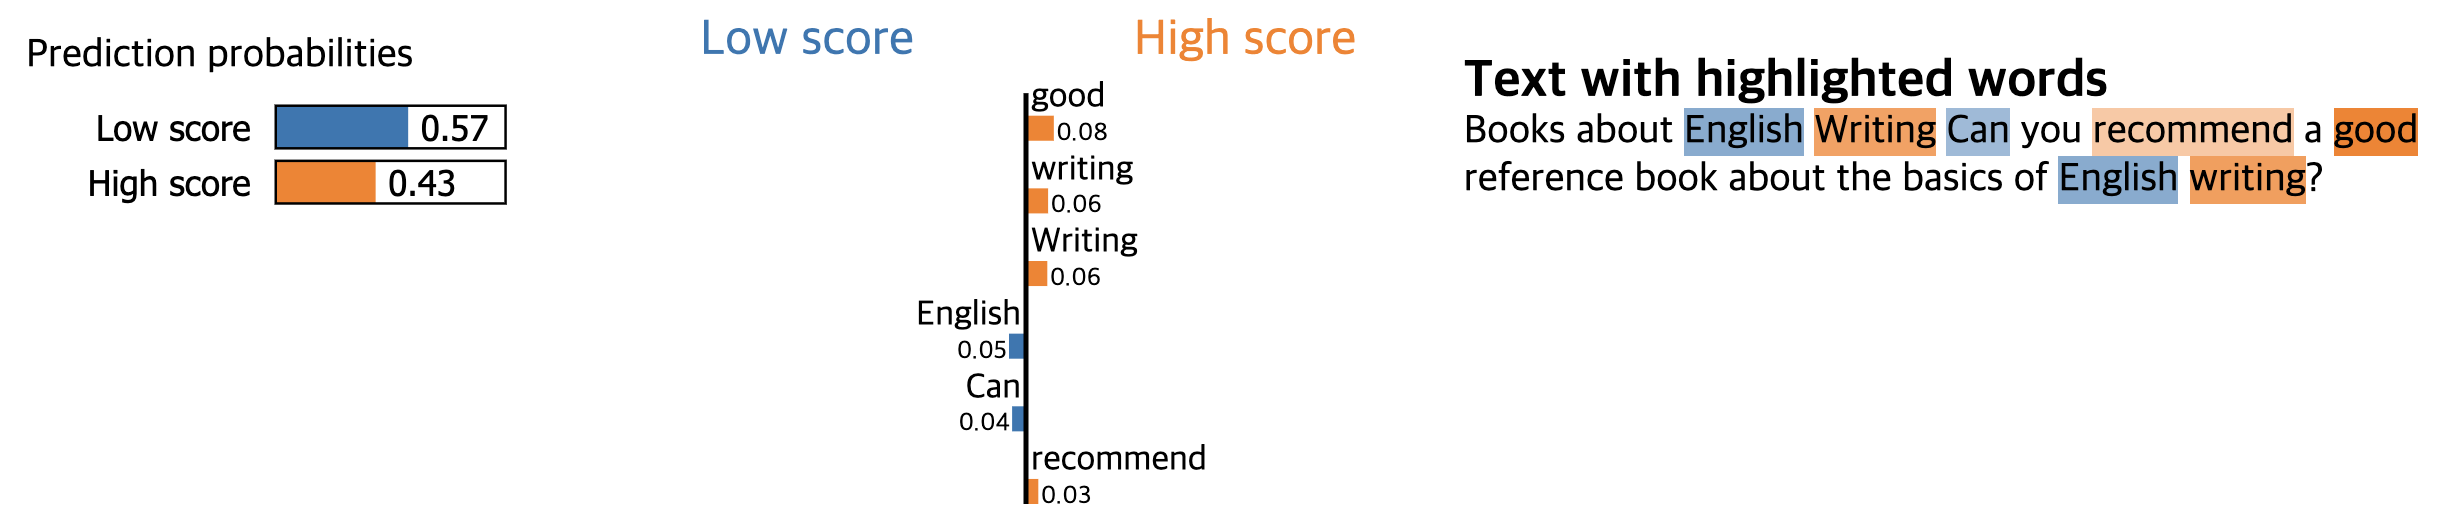

많은 샘플에서 어떤 단어가 모델에 영향을 미쳤는지 아는 것은 가치가 있습니다. 이를 위해 데이터셋에서 여러 샘플을 랜덤하게 추출하여 중요도를 평균합니다.

많은 샘플을 추출하면 단어 중요도를 더 잘 추정할 수 있지만 시간이 오래 걸립니다. 아래 코드에서 500개의 샘플을 사용했을 때 꽤 시간이 걸렸습니다. 이 숫자를 자유롭게 바꿔서 확인해 보세요.

In [ ]:
def get_statistical_explanation(test_set, sample_size, model_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # 먼저, 클래스별 단어의 가중치를 찾습니다
    for sentence in sample_sentences:
        probabilities = model_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, model_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # 단어 가중치를 평균하고 크기에 따라 정렬합니다
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Low score',
    1: 'High score',
}
sorted_contributions = get_statistical_explanation(list(test_df["full_text"]), 500, get_model_probabilities_for_input_texts, label_to_text)

이제 설명 도구를 실행합니다. 전체적으로 가장 중요한 단어를 출력하고 모델에게 좋은 단어인지 알아 보겠습니다.

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Low score', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('High score', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.savefig('images/bmlpa_figures/ch05-13.png', dpi=300)
    plt.show()

In [ ]:
top_words = sorted_contributions['High score']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['High score']['supporters'][:10].tolist()
bottom_words = sorted_contributions['High score']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['High score']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

좋은 질문과 관련된 특성처럼 보이지 않습니다. 높은 점수의 질문을 예측하기 위해 사용한 단어는 그냥 흔히 사용하는 영어 단어입니다. 낮은 점수의 질문을 예측하기 위해 사용한 단어는 글의 형식에 관한 것 같습니다(markup, magazine). 아마도 스택익스체인지의 포스팅 가이드라인을 나타내는 것 같습니다.

이 결과는 모델이 과대적합되었다는 신호입니다. 또는 텍스트 벡터화 처리 과정에서 가장 유용한 정보를 찾지 못했다는 뜻입니다.